In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset_Imgs, load_datasets
from MedSAM_HCP.MedSAM import MedSAM
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.loss_funcs_hcp import *
from segmentation_models_pytorch.encoders import get_preprocessing_fn

/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv'
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)
num_classes=102

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')



In [128]:
train, val, test = load_datasets(
            path,
            '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle',
            label_id = None, bbox_shift=0, 
                sample_n_slices = None, label_converter=label_converter, NUM_CLASSES=num_classes+1, 
                as_one_hot=True, pool_labels=False, preprocess_fn = None, dataset_type = MRIDataset)

train_dl = DataLoader(train, batch_size=64, shuffle=False, num_workers=0)
val_dl = DataLoader(val, batch_size=64, shuffle=False, num_workers=0)
test_dl = DataLoader(test, batch_size=64, shuffle=False, num_workers=0)

In [147]:
def operate(dataloader):
    list_names = []
    list_arr = []
    for step, (image, gt2D, boxes, img_slicename) in enumerate(tqdm(dataloader)):
        list_names.extend(list(img_slicename))
        class_sums = gt2D.sum(dim=(2,3)) # BCHW -> BC
        class_sums = class_sums.detach().cpu().numpy()
        list_arr.append(class_sums)
        if step == 1:
            break
    
    res = np.vstack(list_arr) # N x C
    reto = pd.DataFrame(res, columns = [f'label{x}' for x in range(0,103)])
    reto = reto.drop('label0', axis=1)

    reto['id'] = [x.split('_')[0] for x in list_names]
    reto['slice'] = [int(x.split('_slice')[1].split('.npy')[0]) for x in list_names]
    order = ['id', 'slice']
    for i in range(1,103):
        order.append(f'label{i}')
    reto = reto.loc[:, order]
    return reto
reto = operate(train_dl)

  0%|          | 1/3564 [00:12<12:38:23, 12.77s/it]


In [148]:
reto

,id,slice,label1,label2,label3,label4,label5,label6,label7,label8,...,label93,label94,label95,label96,label97,label98,label99,label100,label101,label102
0,100206,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,100206,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100206,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,100206,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100206,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,100206,123,4811,25,0,0,0,0,0,0,...,213,313,0,607,341,223,0,310,0,0
124,100206,124,4925,78,0,0,0,0,19,0,...,210,258,0,610,334,184,0,336,0,0
125,100206,125,4895,127,0,0,0,0,72,0,...,197,235,0,610,300,164,0,398,0,0
126,100206,126,4824,172,0,0,0,0,112,0,...,182,221,0,568,288,137,0,455,0,0


In [ ]:
cnts_1 = []
cnts_5 = []
cnts_7 = []

for step, (image, gt2D) in enumerate(tqdm(train_loader)):
    gt2D = gt2D.to('cuda') # B x C x H x W

    cnt_nparr = gt2D.sum(dim=(2,3)).cpu().detach().numpy() # B x C
    cnts_1.extend(cnt_nparr[:, 0].tolist())
    cnts_5.extend(cnt_nparr[:, 4].tolist())
    cnts_7.extend(cnt_nparr[:, 6].tolist())

168.0
53.5
26.0


Text(0.5, 1.0, 'Label 7')

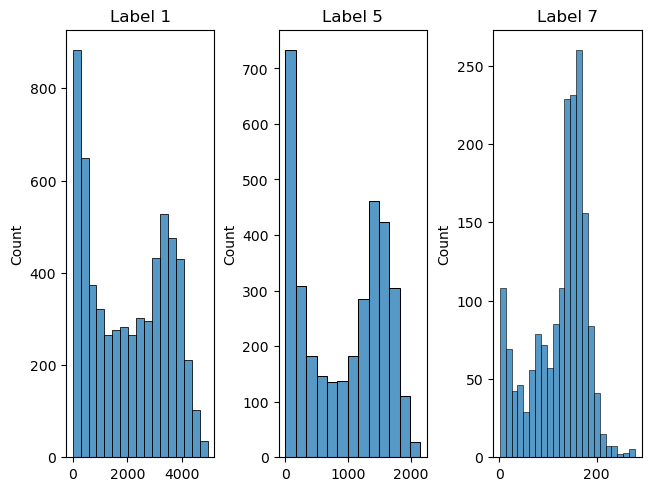

In [64]:
cnts1f = [x for x in cnts_1 if x > 0]
cnts5f = [x for x in cnts_5 if x > 0]
cnts7f = [x for x in cnts_7 if x > 0]
print(np.quantile(cnts1f, 0.1))
print(np.quantile(cnts5f, 0.1))
print(np.quantile(cnts7f, 0.1))

fig, axs = plt.subplots(1, 3, squeeze=False, constrained_layout=True)
sns.histplot(cnts1f, ax = axs[0,0])
axs[0,0].set_title('Label 1')

sns.histplot(cnts5f, ax = axs[0,1])
axs[0,1].set_title('Label 5')

sns.histplot(cnts7f, ax = axs[0,2])
axs[0,2].set_title('Label 7')

In [28]:
comb_df

,id,slice,image_embedding_slice_path,segmentation_slice_path,image_path,bbox_0,bbox_1,bbox_2,bbox_3
0,100206,150,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,86.0,129.0,103.0,140.0
1,100206,151,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,86.0,128.0,100.0,134.0
2,100206,152,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,88.0,127.0,103.0,134.0
3,100206,153,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,87.0,126.0,103.0,134.0
4,100206,154,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,84.0,127.0,103.0,135.0
...,...,...,...,...,...,...,...,...,...
68058,996782,206,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,83.0,133.0,97.0,156.0
68059,996782,207,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,82.0,133.0,97.0,146.0
68060,996782,208,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN
68061,996782,209,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/pr...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/se...,/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/di...,NaN,NaN,NaN,NaN


In [ ]:
label = 7

# is there association between which slices yolo detects vs does not detect?
df_boxes = pd.read_csv(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/yolov10/100/{label}/path_df_only_with_bbox_yolov10.csv')
total_df = pd.read_csv(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/{label}/0/isolated_path_df_constant_bbox.csv')
total_df = total_df.drop(columns = ['bbox_0', 'bbox_1', 'bbox_2', 'bbox_3'])
comb_df = total_df.merge(df_boxes, how='left', on=['id','slice','image_embedding_slice_path', 'segmentation_slice_path', 'image_path'])

df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv(f'/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)
num_classes=102
ds = MRIDataset(comb_df, label_id = label, label_converter = label_converter,
    NUM_CLASSES = 2)
dl = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)

cnts_dict_from_yolo = {'cnt':[], 'was_detected':[]}
for step, (image, gt2D, boxes, _) in enumerate(tqdm(dl)):
    gt2D = gt2D.to('cuda') # B x C x H x W

    cnt_nparr = gt2D.sum(dim=(1,2,3)).cpu().detach().numpy() # B
    was_detected = ~boxes.isnan().all(dim=1).cpu().detach().numpy()

    cnts_dict_from_yolo['cnt'].extend(cnt_nparr.tolist())
    cnts_dict_from_yolo['was_detected'].extend(was_detected.tolist())


 74%|███████▍  | 785/1064 [42:41<15:10,  3.26s/it]  


KeyboardInterrupt: 

In [24]:
dfo[(dfo['was_detected']==True)]

,pixel_count,was_detected
0,0,True
1,0,True
2,0,True
3,0,True
4,0,True
...,...,...
313,0,True
316,0,True
317,0,True
318,0,True


<Axes: xlabel='pixel_count', ylabel='Count'>

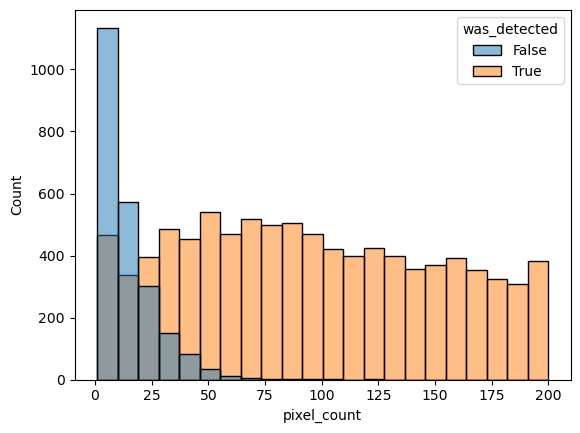

In [67]:

dfo = pd.DataFrame(cnts_dict_from_yolo)
dfo = dfo.rename({'cnt': 'pixel_count'}, axis=1)
dfo
sns.histplot(dfo[(0 < dfo['pixel_count']) & (dfo['pixel_count']<= 200)], x = 'pixel_count', hue = 'was_detected')

In [118]:
### Generate eval dataframe for the certain number of pixels
256 * 1113 * 102

29062656